[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kmaussang/JupyterNotebookPhysics/main?filepath=Atmosphere.ipynb)

# Profil de pression de l'atmosphère

## Modèle de l'atmosphère isotherme

Equation de l'hydrostatique :
$$ \frac{\text{d} P}{\text{d}z}=-\rho g.$$
Pour un gaz parfait, $\rho=\frac{MP}{RT}$, avec $M$ la masse molaire, $R$ constante des gaz parfaits, $T$ la température.

In [1]:
# import des librairies usuelles
import numpy as np
import scipy.integrate as itg
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True) # pour utiliser LaTeX dans les figures

### Définition des constantes et paramètres de calcul

In [2]:
M=0.029 # kg/mol
R=8.314 # USI
g=9.81 # USI
To=288 # in K
hc=R*To/(M*g) # longueur caractéristique
print("Echelle spatiale caractéristique, hc={:.2f}km".format(hc/1e3))
z_max=35e3
z=np.linspace(0,z_max,100) # vecteur altitude

Echelle spatiale caractéristique, hc=8.42km


### Méthode d'Euler pour la résolution numérique de l'équation différentielle

Soit $f(x)$ une fonction de classe $\mathcal{C}^1$ sur $\mathbb{R}$ inconnue mais dont on connait la valeur en $x_0$ ($y_0=f(x_0)$) et une équation différentielle vérifiée par $f(x)$. Elle permet de calculer numériquement la fonction $f(x)$ sur un intervalle $[x_0,x_f]$. On suppose qu'il existe une fonction $F(y,x)$ de classe $\mathcal{C}^0$ telle que $f(x)$ vérifie l'équation différentielle suivante
$$\frac{\text{d}f}{\text{d}x}=F(f(x),x).$$ 

La méthode d'Euler consiste est exploiter le développement limité d'une fonction autour d'un point $x$. Soit $(x,h) \in \mathbb{R}$ avec $h \ll 1$. On a alors
$$ f(x+h) \approx f(x) +h \frac{\text{d}f}{\text{d}x},$$
soit
$$ f(x+h) \approx f(x) +h F(f(x),x).$$
Désormais on discrétise la variable $x$ sur l'intervalle $[x_0,x_f]$ en $n+1$ points discrets de la forme
$$x_k=x_0+kh \text{ pour } k \in  [\![ 0, n ]\!].$$
On approxime alors la solution $y=f(x)$ en $x_k$ par le nombre $y_k$ défini par la relation de récurrence
$$ y_{k+1}=y_k + h F(y_k,t_k),$$
avec une initialisation sur la condition initiale $y_0=y(t_0)$.

Avec Python, la méthode d'Euler est implémenté par la méthode ```odeint``` de la librairie ```scipy.integrate```. Cette méthode permet de résoudre des équations différentielles de la forme $y'(x)=F(y(x),x)$ de condition initiale $y_0=y(x_0)$. Elle prend pour argument la fonction $F$ (déclarée comme une fonction Python, la condition initiale $y_0$ et une liste de valeurs de $x$ pour lesquelles on souhaite calculer la fonction $f(x)$. La syntaxe générale de ce module est de la forme ```Y=odeint(```fonction```,```valeur initiale```,```intervalle de calcul```)``` 

Par exemple : résoudre $y'=y$ sur l'intervalle $[0,1]$ avec $y(0)=0$. 
1) On définit la fonction numérique $F$ telle que $y'=F(y,x)$ :
```def F(y,t)
    return y```
    
2) On construit une liste de valeurs de $x$ pour lesquelles on souhaite connaitre $f(x)$, cette liste étant initiée en $x_0=0$, avec 100 points pour effectuer le calcul :
```x = np.linspace(0,1,99)```

3) Enfin, la méthode ```odeint``` permet d'obtenir une liste de valeur $y$ correspondant à la solution, assignés à la variable ```Y``` :
```Y = odeint(F,1,x)```

### Méthode d'Euler appliquée au calcul du profil de pression dans différents modèles d'atmosphères

Pour un profil de température quelconque $T(z)$, on cherche a calculer le champ de pression $P(s)$. On a alors l'équation différentielle vérifiée par $P(z)$ que l'on peut écrire sous la forme
$$ \frac{\text{d} P}{\text{d}z}=-\frac{Mg}{RT(z)} P(z)=F(P(z),z),$$
avec
$$F(y,z)=-\frac{Mg}{RT(z)} y.$$

In [3]:
def F(P, z):
    return -M*P*g/(R*To)

P = itg.odeint(F, [1], z) # résolution de l'équation différentielle

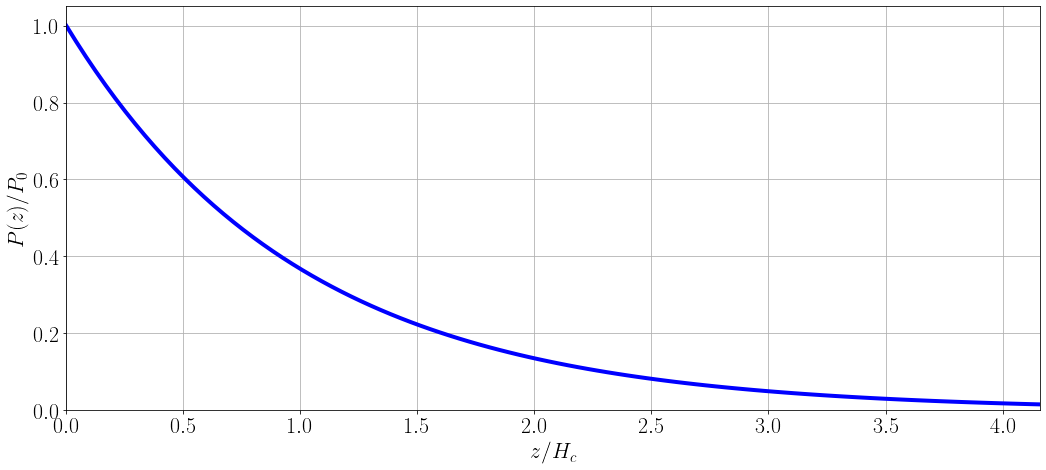

In [4]:
fig=plt.figure(1, figsize=(15, 7))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(z/hc,P,"b-", linewidth=4)
plt.xlabel(r'$z/H_c$')
plt.ylabel(r'$P(z)/P_0$ ')
plt.grid()
plt.xlim(0,z_max/hc)
plt.ylim(0,1.05)
plt.tight_layout()
plt.show()

### Estimation de l'erreur numérique

La solution analytique est
$$ P(z)=P_0 e^{-z/H_c},$$
avec
$$ H_c=\frac{RT_0}{Mg}.$$
Il est possible alors d'estimer $E_{num}(z)$ l'erreur numérique relative selon
$$ E_{num}(z)=\frac{P_{num}(z)-P(z)}{P(z)},$$
où $P_{num}(z)$ est la pression calculée numériquement et $P(z)$ l'expression analytique.

In [5]:
E=P.flatten()*np.exp(z/hc)-1

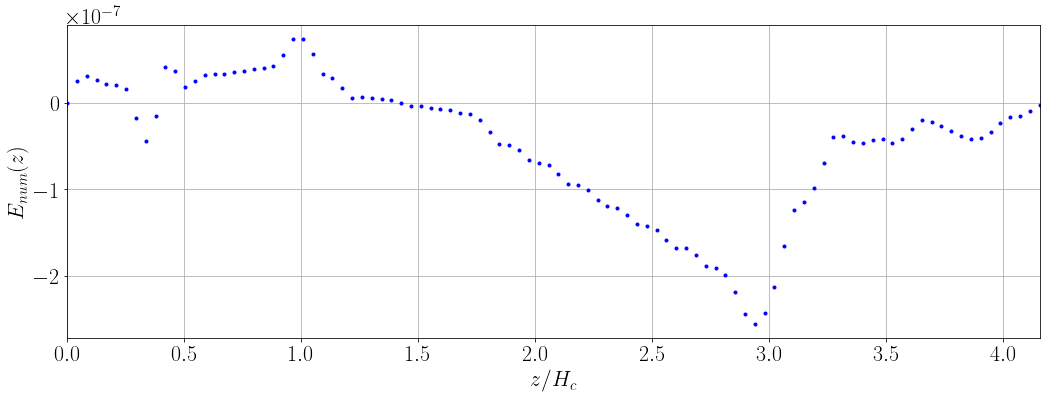

In [6]:
fig=plt.figure(1, figsize=(15, 6))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(z/hc,E,"b.", linewidth=4)
plt.xlabel(r'$z/H_c$')
plt.ylabel(r'$E_{num}(z)$ ')
plt.grid()
plt.xlim(0,z_max/hc)
plt.tight_layout()
plt.show()

## Modèle à gradient de température

Un modèle plus élaboré consiste à proposer un dépendance linéaire de la température avec l'altitude
$$T(z)=T_0+az.$$

### Résolution numérique

In [7]:
a=-6.5e-3 # K/m

def F2(P2, z):
    return -M*P2*g/(R*(To+a*z))

P2 = itg.odeint(F2, [1], z) # résolution de l'équation différentielle

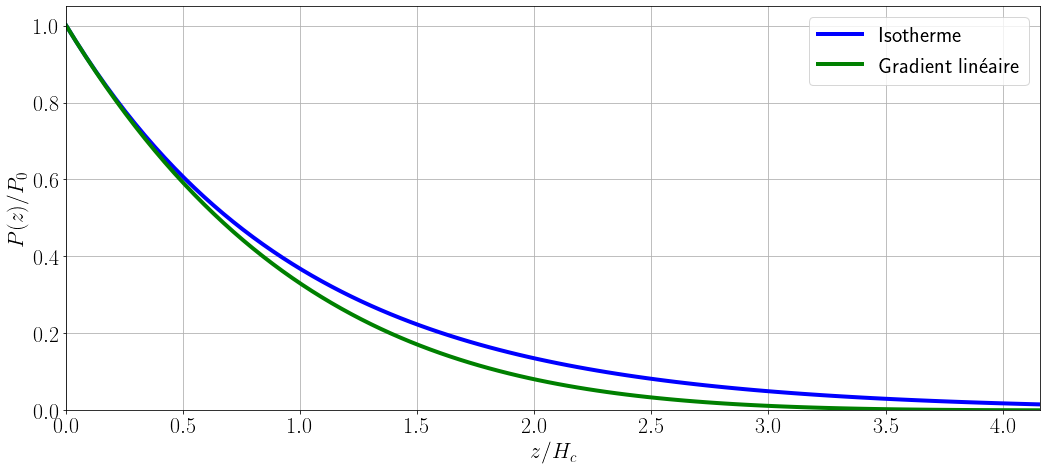

In [8]:
fig=plt.figure(1, figsize=(15, 7))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(z/hc,P,"b-", linewidth=4)
plt.plot(z/hc,P2,"g-", linewidth=4)
plt.xlabel(r'$z/H_c$')
plt.ylabel(r'$P(z)/P_0$ ')
plt.legend(['Isotherme','Gradient linéaire'])
plt.grid()
plt.xlim(0,z_max/hc)
plt.ylim(0,1.05)
plt.tight_layout()
plt.show()

### Estimation de l'erreur numérique

La solution analytique est
$$ P(z)=P_0 \left( 1+ \frac{az}{T_0}\right) ^{\beta},$$
avec
$$ \beta=-\frac{Mg}{Ra}.$$

In [9]:
beta=-M*g/(R*a)
E2=(P2.flatten()-(1+a*z/To)**beta)/(1+a*z/To)**beta

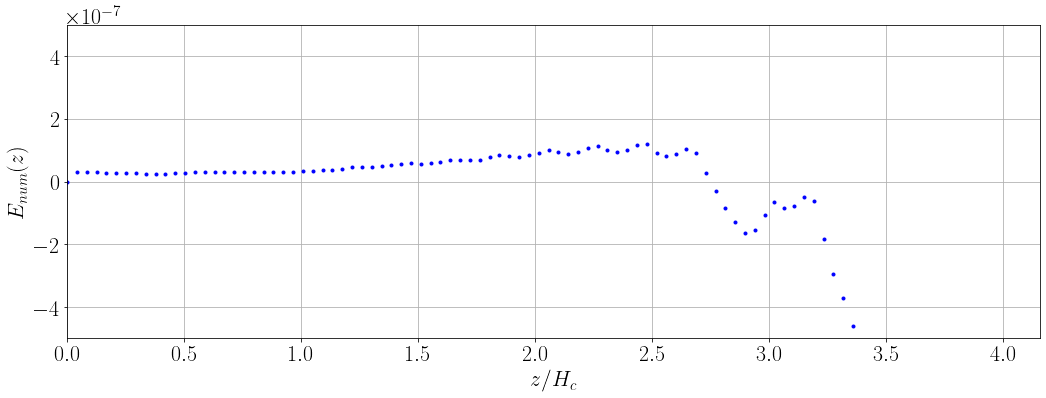

In [10]:
fig=plt.figure(1, figsize=(15, 6))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(z/hc,E2,"b.", linewidth=4)
plt.xlabel(r'$z/H_c$')
plt.ylabel(r'$E_{num}(z)$ ')
plt.grid()
plt.xlim(0,z_max/hc)
plt.ylim(-0.5e-6,0.5e-6)
plt.tight_layout()
plt.show()

## Atmosphère dite "ISA"

L'atmosphère standard dite « ISA » (International Standard Atmosphere) est un modèle divisant l'atmosphère en différentes couches avec une distribution linéaire de la température. L'organisation internationale de normalisation (ISO pour *International Organization for Standardization*) publie l'atmosphère type internationale (ISA) comme norme, ISO 2533:19751. D'autres organismes de normalisation, comme l'organisation de l'aviation civile internationale et le gouvernement des États-Unis, publient, sous leur propre autorité, des prolongements ou des sous-ensembles de normes pour le même modèle atmosphérique. 

*Extrait de* https://fr.wikipedia.org/wiki/Atmosph%C3%A8re_normalis%C3%A9e

### Profil de température d'une atmosphère ISA

In [11]:
def T_ISA(z):
    tmp=[]
    if not np.isscalar(z):
        for x in list(z):
            if x<11e3: tmp.append(288-x*6.5e-3)
            elif (x<20e3 and x>=11e3):  tmp.append(216.5)
            elif (x<32e3 and x>=20e3):  tmp.append(216.5+(x-20e3)*1e-3)
            elif (x<47e3 and x>=32e3):  tmp.append(228.5+2.8*(x-32e3)*1e-3)
            elif (x<51e3 and x>=47e3):  tmp.append(270.5)
            elif (x<71e3 and x>=51e3):  tmp.append(270.5-2.8*(x-51e3)*1e-3)
            else: tmp.append(214.5-2*(x-71e3)*1e-3)
        return np.array(tmp)
    else:
        if z<11e3: return 288-z*6.5e-3
        elif (z<20e3 and z>=11e3):  return 216.5
        elif (z<32e3 and z>=20e3):  return 216.5+(z-20e3)*1e-3
        elif (z<47e3 and z>=32e3):  return 228.5+2.8*(z-32e3)*1e-3
        elif (z<51e3 and z>=47e3):  return 270.5
        elif (z<71e3 and z>=51e3):  return 270.5-2.8*(z-51e3)*1e-3
        else: return 214.5-2*(z-71e3)*1e-3

In [12]:
# z_isa, pour représentation graphique du profil de température
z_isa=np.linspace(0,80e3,500) # vecteur altitude

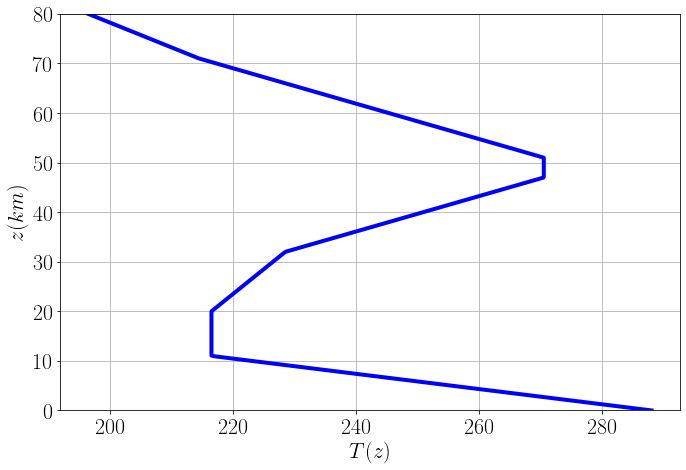

In [13]:
fig=plt.figure(1, figsize=(10, 7))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(T_ISA(z_isa),z_isa/1e3,"b-", linewidth=4)
plt.ylabel(r'$z (km)$')
plt.xlabel(r'$T(z)$ ')
plt.grid()
plt.ylim(0,z_isa.max()/1e3)
plt.tight_layout()
plt.show()

### Champ de pression dans le cas d'un profil de température d'une atmosphère ISA

In [14]:
def F3(P3, z):
    return -M*P3*g/(R*T_ISA(z))

P3 = itg.odeint(F3, [1], z) # résolution de l'équation différentielle

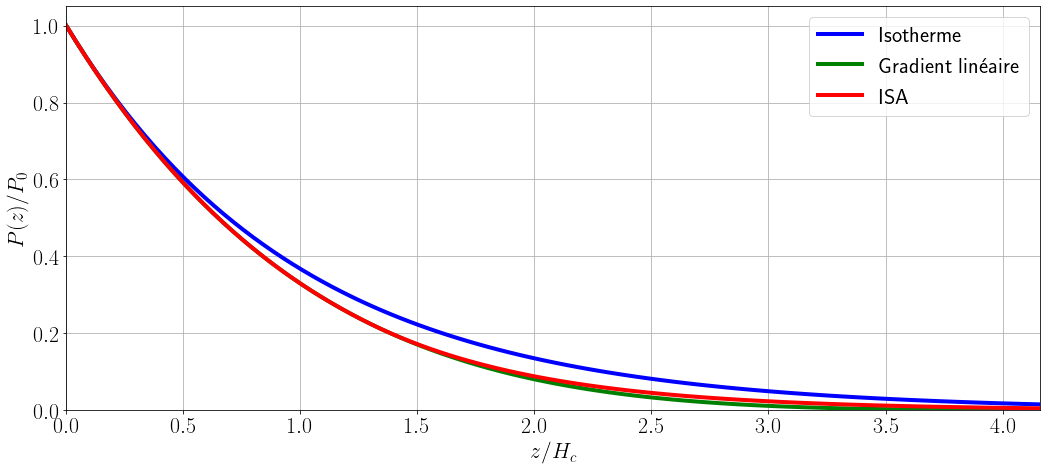

In [15]:
fig=plt.figure(1, figsize=(15, 7))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(z/hc,P,"b-", linewidth=4)
plt.plot(z/hc,P2,"g-", linewidth=4)
plt.plot(z/hc,P3,"r-", linewidth=4)
plt.xlabel(r'$z/H_c$')
plt.ylabel(r'$P(z)/P_0$ ')
plt.legend(['Isotherme','Gradient linéaire','ISA'])
plt.grid()
plt.xlim(0,z_max/hc)
plt.ylim(0,1.05)
plt.tight_layout()
plt.show()

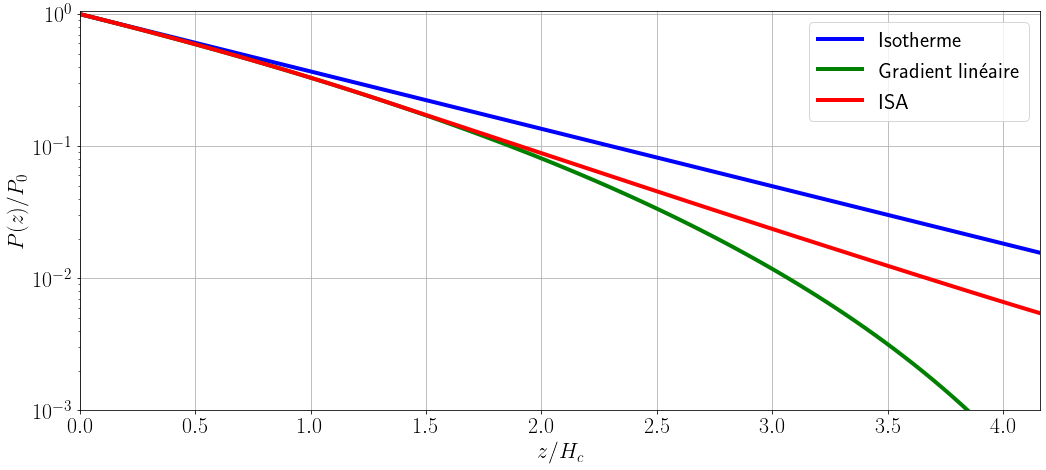

In [16]:
# représentation en échelle log-lin
fig=plt.figure(1, figsize=(15, 7))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(z/hc,P,"b-", linewidth=4)
plt.plot(z/hc,P2,"g-", linewidth=4)
plt.plot(z/hc,P3,"r-", linewidth=4)
plt.xlabel(r'$z/H_c$')
plt.ylabel(r'$P(z)/P_0$ ')
plt.legend(['Isotherme','Gradient linéaire','ISA'])
plt.grid()
plt.xlim(0,z_max/hc)
plt.ylim(0.001,1.05)
plt.yscale('log')
plt.tight_layout()
plt.show()